In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sax
from simphony.quantum import QuantumSim,compose_qstate,CoherentState,SqueezedState
from functools import partial
import jax
import quantp as qp
import thewalrus as tw
from simphony.quantum import plot_quantum_result
from simphony.classical import ClassicalSim
from scipy.special import factorial
import jax.numpy as jnp
from scipy.stats import multivariate_normal
from thewalrus import _hafnian as hf
from thewalrus.quantum.conversions import Amat,Qmat


In [4]:


def one_mode_plot(mu,cov,ax,row,col):
   
    means=mu
    cov=cov

    # fig, ax = plt.subplots()
    x_max = means[0]+5
    y_max = means[1]+5
    r_max = jnp.max(jnp.array((x_max, y_max)))

    x_min = means[0]-5
    y_min = means[1]-5
    r_min = jnp.min(jnp.array((x_min, y_min)))

    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
   

    # x_range = (r_min, r_max)
    # y_range = (r_min, r_max)
    n=100
    x = jnp.linspace(x_range[0], x_range[1], n)
    y = jnp.linspace(y_range[0], y_range[1], n)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))
    dist = multivariate_normal(means, cov)
    pdf = dist.pdf(pos)
    ax[row,col].contourf(X, Y, pdf)
    ax[row,col].set_aspect("equal")
    ax[row,col].set_xlabel("X")
    ax[row,col].set_ylabel("P")
    return ax[row,col]



def mode_plot(res):
    mode=res.n_ports
    N=mode*2

    means=np.array(res.means[0])
    cov=res.cov

    u=1
    fig_ind=1
    ind=int(mode/2)
    ind=int(np.sqrt(mode))
    fig,ax=plt.subplots(ind,ind,figsize=(10,10))
    for i in range(res.n_ports):
        
        # ax=plt.subplot(ind,ind,i+1)
        mu=[means[i],means[i+N]]
        covar=np.array([[cov[u][i][i],cov[u][i][i+1]],
             [cov[u][i+1][i],cov[u][i+1][i+1]]])
        
    # Calculate row and column index
        row = i // 4
        col = i % 4
        
        one_mode_plot(mu,covar,ax,row,col)
    plt.tight_layout()
    plt.show

In [5]:

def phot_cir(M=8,num_layer=8,wl=1.55):

    #num of inputs/output=m*2
    #width if mesh=n
    m=M//2
    n=num_layer//2

    t_no=m*n+(n-1)*(m)
    instances={}
    for t in range(1,t_no+1):
        var=f"{'S'}{t}"
        instances[var]='SU2'


    p_ar=[1,0]*m
    q_ar=[0,1]*m

    mesh_arr=[p_ar,q_ar]
    mesh=np.transpose(mesh_arr*n)
    mesh=mesh[:-1]   ## if the out put waveguide layer  should match with input layer
    # Mesh=mesh
    port_no=int(int(mesh.shape[0]+1)/2)




        
    conn_dict={}
    name_dict={}
    num=1
    for j in range(mesh.shape[1]):   # for j in range(mesh.shape[1]-1): 
        for i in range(mesh.shape[0]):



            if mesh[i][j]==1:
                string=f'({i},{j})'
                name_dict[str(num)]=[]
                name_dict[str(num)].append(string)
                num+=1

                if i==0  :
                    
                    conn_dict[string]=[]
                    conn_dict[string].append([[f'({i},{j+2})'],[f'({i+1},{j+1})']])
                elif i==mesh.shape[0]-1 :
                    
                    conn_dict[string]=[]
                    conn_dict[string].append([[f'({i-1},{j+1})'],[f'({i},{j+2})']])
                    
                else:
                    
                    conn_dict[string]=[]
                    conn_dict[string].append([[f'({i-1},{j+1})'],[f'({i+1},{j+1})']])


        

    conn={}
    port_num=int(int(mesh.shape[0]+1)/2)
    p1=1
    p2=port_num
    for ckey,cvalue in conn_dict.items():
        for nkey,nvalue in name_dict.items():      


            if ckey == nvalue[0]:

                # if int(nkey)>t_no-(port_num+(port_num-1)):             
                if int(nkey)==p1 :
                    string1=f"S{nkey},outt"
                    string2=f"S{nkey},outb"
                    conn[string1]=[]
                    conn[string2]=[]
                    p1+=(port_num+(port_num-1))                

                    for nkey1,nvalue1 in name_dict.items():
                        if cvalue[0][0]==nvalue1:
                            conn[string1]=f"S{nkey1},int"
                        if cvalue[0][1]==nvalue1:
                            conn[string2]=f"S{nkey1},int"

                elif  int(nkey)== p2:
                    string1=f"S{nkey},outt"
                    string2=f"S{nkey},outb"
                    conn[string1]=[]
                    conn[string2]=[]
                    
                    p2+=(port_num+(port_num-1))

                    for nkey1,nvalue1 in name_dict.items():
                        if cvalue[0][0]==nvalue1:
                            conn[string1]=f"S{nkey1},inb"
                        if cvalue[0][1]==nvalue1:
                            conn[string2]=f"S{nkey1},inb"      



                else:    
                    string1=f"S{nkey},outt"
                    string2=f"S{nkey},outb"
                    conn[string1]=[]
                    conn[string2]=[]

                    for nkey1,nvalue1 in name_dict.items():
                        if cvalue[0][0]==nvalue1:
                            conn[string1]=f"S{nkey1},inb"
                        if cvalue[0][1]==nvalue1:
                            conn[string2]=f"S{nkey1},int"




    pdict={}
    pind=1
    loop=2
    connections={}


    for kval,vval in conn.items():
        if vval==[]:
            if pind==loop:
                last_val=kval
                loop-=1
            else:
                pdict[pind]=[]
                pdict[pind]=[kval]
                pind+=1   
        else:
            connections[kval]=[]
            connections[kval]=[vval][0]

    pdict[pind]=[]
    pdict[pind]=[last_val]
    


    ports={}
    o=1
    for p in range(1,(port_no)+1):
        
        kin1=f"int{p}"
        kin2=f"inb{p}"

        kout1=f"outt{p}"
        kout2=f"outb{p}"

        ports[kin1]=[]
        ports[kin2]=[]
        ports[kin2]=[]
        ports[kout2]=[]

        
        ports[kin1]=f"S{p},int"
        ports[kin2]=f"S{p},inb"
        ports[kout1]=pdict[o][0]
        ports[kout2]=pdict[o+1][0]
        o+=2
        
           
    return instances,connections,ports

In [6]:


def sampler(a,b,c,wl,theta_arr=None,phi_arr=None):
       ##circuit
    if theta_arr is None  :
        theta_arr=np.zeros(len(a))
        print('theta array is None')
    if phi_arr is None:
        phi_arr=np.zeros(len(a))
        print('phi array is None')
    cir,info=sax.circuit(
        netlist={
            "instances":a,
            "connections":b,
            "ports":c
        },
        models={'SU2':partial(qp.trr)}) 
    
    su_dict={}
    i=0
    for key in range(len(a)):
        su_dict[key]={"theta":theta_arr[i],"phi":phi_arr[i]}
        i+=1
    
    val=cir(wl=wl,    S1=su_dict[0],
                      S2=su_dict[1],
                      S3=su_dict[2],
                      S4=su_dict[3],
                      S5=su_dict[4],
                      S6=su_dict[5],
                      S7=su_dict[6],
                      S8=su_dict[7],
                      S9=su_dict[8],
                      S10=su_dict[9],
                      S11=su_dict[10],
                      S12=su_dict[11],
                      S13=su_dict[12],
                      S14=su_dict[13],
                      S15=su_dict[14],
                      S16=su_dict[15],
                      S17=su_dict[16],
                      S18=su_dict[17],
                      S19=su_dict[18],
                      S20=su_dict[19],
                      S21=su_dict[20],
                      S22=su_dict[21],
                      S23=su_dict[22],
                      S24=su_dict[23],
                      S25=su_dict[24],
                      S26=su_dict[25],
                      S27=su_dict[26],
                      S28=su_dict[27],
                      
    )
    return val

In [7]:

def haar_random_unitary(n):
   
    U = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    
    Q, R = np.linalg.qr(U)
    
    
    d = np.diagonal(R)
    ph = d / np.abs(d)
    Q = np.multiply(Q, ph, Q)
    
    return Q

def clements_decomposition(U):
    
    n = U.shape[0]
    theta = []
    phi = []
    
    V = U.copy()
    for i in range(n-1):
        for j in range(i+1, n):
            a = V[i,i]
            b = V[j,i]
            r = np.sqrt(np.abs(a)**2 + np.abs(b)**2)
            theta_ij = 2 * np.arctan2(np.abs(b), np.abs(a))
            phi_ij = np.angle(b) - np.angle(a)
            theta.append(theta_ij)
            phi.append(phi_ij)
            c = a / r
            s = b / r
            V[:,i] = c * V[:,i] + np.conj(s) * V[:,j]
            V[:,j] = -s * V[:,i] + c * V[:,j]

    theta = np.mod(theta, 2 * np.pi)
    phi = np.mod(phi, 2 * np.pi)
    
    return np.array(theta), np.array(phi)


def angles(n):
    U = haar_random_unitary(n)
    theta_arr, phi_arr = clements_decomposition(U)
    # print('theta:\n', theta_arr)
    # print("phi:\n", phi_arr)
    # print(len(phi_arr))
    theta_arr=np.multiply(theta_arr,(1/(2*np.pi)))
    phi_arr=np.abs(np.multiply(phi_arr,(1/(2*np.pi))))
    return theta_arr, phi_arr

In [8]:
angles(8)

(array([0.14082777, 0.16624446, 0.1175538 , 0.11960152, 0.12437218,
        0.10613471, 0.15548449, 0.37913718, 0.3229311 , 0.10505303,
        0.0723046 , 0.14991701, 0.11626781, 0.29017321, 0.27036645,
        0.3845367 , 0.15375617, 0.230742  , 0.11344657, 0.16417345,
        0.1461894 , 0.06398925, 0.26640863, 0.37648922, 0.43014685,
        0.31069212, 0.30251206, 0.19952183]),
 array([0.82746226, 0.89083853, 0.89247147, 0.17051761, 0.37127999,
        0.14735408, 0.27230707, 0.57615847, 0.50338384, 0.80099196,
        0.07636897, 0.37616527, 0.2928541 , 0.79018433, 0.8986531 ,
        0.93992864, 0.57127823, 0.18465231, 0.46202679, 0.55339837,
        0.48769267, 0.05877671, 0.99882451, 0.41915291, 0.35508713,
        0.07875395, 0.18954412, 0.18287861]))

In [42]:
# theta_arr=np.random.rand(28)
# phi_arr=np.random.rand(28)
# theta_arr=np.multiply(theta_arr,0.5)

In [9]:
inst,conn,ports=phot_cir(8,8)
r=sampler(inst,conn,ports,wl=1.55)

theta array is None
phi array is None


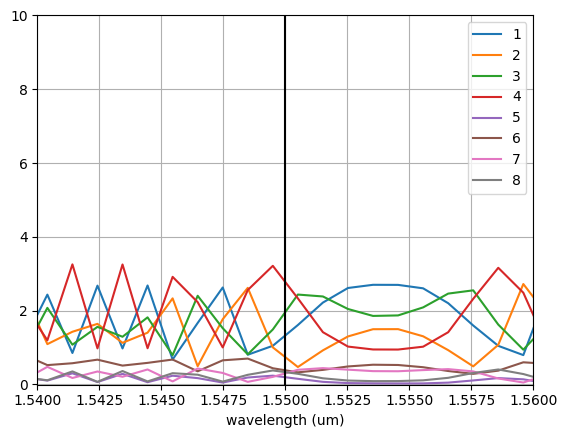

In [433]:
wl=np.linspace(1.5,1.6,100)
theta_arr,phi_arr=angles(8)

f=plt.figure()

k=1

# theta_arr=np.random.rand(28)
# theta_arr=np.multiply(0.5,theta_arr)
# theta_arr=np.ones(28)*0.125


sim3=ClassicalSim(ckt=sampler,wl=wl,a=inst,b=conn,c=ports,theta_arr=theta_arr,phi_arr=phi_arr)
laser_1 = sim3.add_laser(ports=["int1"], power=0.0)
laser_2 = sim3.add_laser(ports=["inb1"], power=0.0)
laser_3 = sim3.add_laser(ports=["int2"], power=0.0)
laser_4 = sim3.add_laser(ports=["inb2"], power=8.0)

laser_5 = sim3.add_laser(ports=["int3"], power=0.0)
laser_6 = sim3.add_laser(ports=["inb3"], power=0.0)
laser_7 = sim3.add_laser(ports=["int4"], power=0.0)
laser_8 = sim3.add_laser(ports=["inb4"], power=0.0)


detector_1 = sim3.add_detector(ports=["outt1"])
detector_2 = sim3.add_detector(ports=["outb1"])
detector_3 = sim3.add_detector(ports=["outt2"])
detector_4 = sim3.add_detector(ports=["outb2"])

detector_5 = sim3.add_detector(ports=["outt3"])
detector_6 = sim3.add_detector(ports=["outb3"])
detector_7 = sim3.add_detector(ports=["outt4"])
detector_8 = sim3.add_detector(ports=["outb4"])
result = sim3.run()
        



plt.plot(wl, np.abs(result.sdict['outt1'])**2, label='1')
plt.plot(wl, np.abs(result.sdict['outb1'])**2, label='2')
plt.plot(wl, np.abs(result.sdict['outt2'])**2, label='3')
plt.plot(wl, np.abs(result.sdict['outb2'])**2, label='4')

plt.plot(wl, np.abs(result.sdict['outt3'])**2, label='5')
plt.plot(wl, np.abs(result.sdict['outb3'])**2, label='6')
plt.plot(wl, np.abs(result.sdict['outt4'])**2, label='7')
plt.plot(wl, np.abs(result.sdict['outb4'])**2, label='8')

plt.axvline(x=1.55, color='k')
plt.legend()
plt.grid()
plt.ylim([-0.01,10.01])
plt.xlim([1.49,1.61])
plt.xlim([1.54,1.56])
# plt.title('theta-phi= '+ '('+str(i1)+','+ str(j1)+'), ('+str(i2)+','+str(j2)+'), ('+str(i3)+','+str(j3)+')')
plt.xlabel("wavelength (um)")
k=k+1


 


In [23]:
1/2*2

1.0

In [12]:

mean_photon_number = 1


r = np.arcsinh(np.sqrt(mean_photon_number))

print("Sq  param: ")
print(r)


Sq  param: 
0.881373587019543


In [13]:
# r=0.6
s_sq = np.sinh(r)**2
alpha_sq = 1 - s_sq

if alpha_sq >= 0:
    alpha = np.sqrt(alpha_sq)
else:
    alpha = None


print(alpha)


0.0


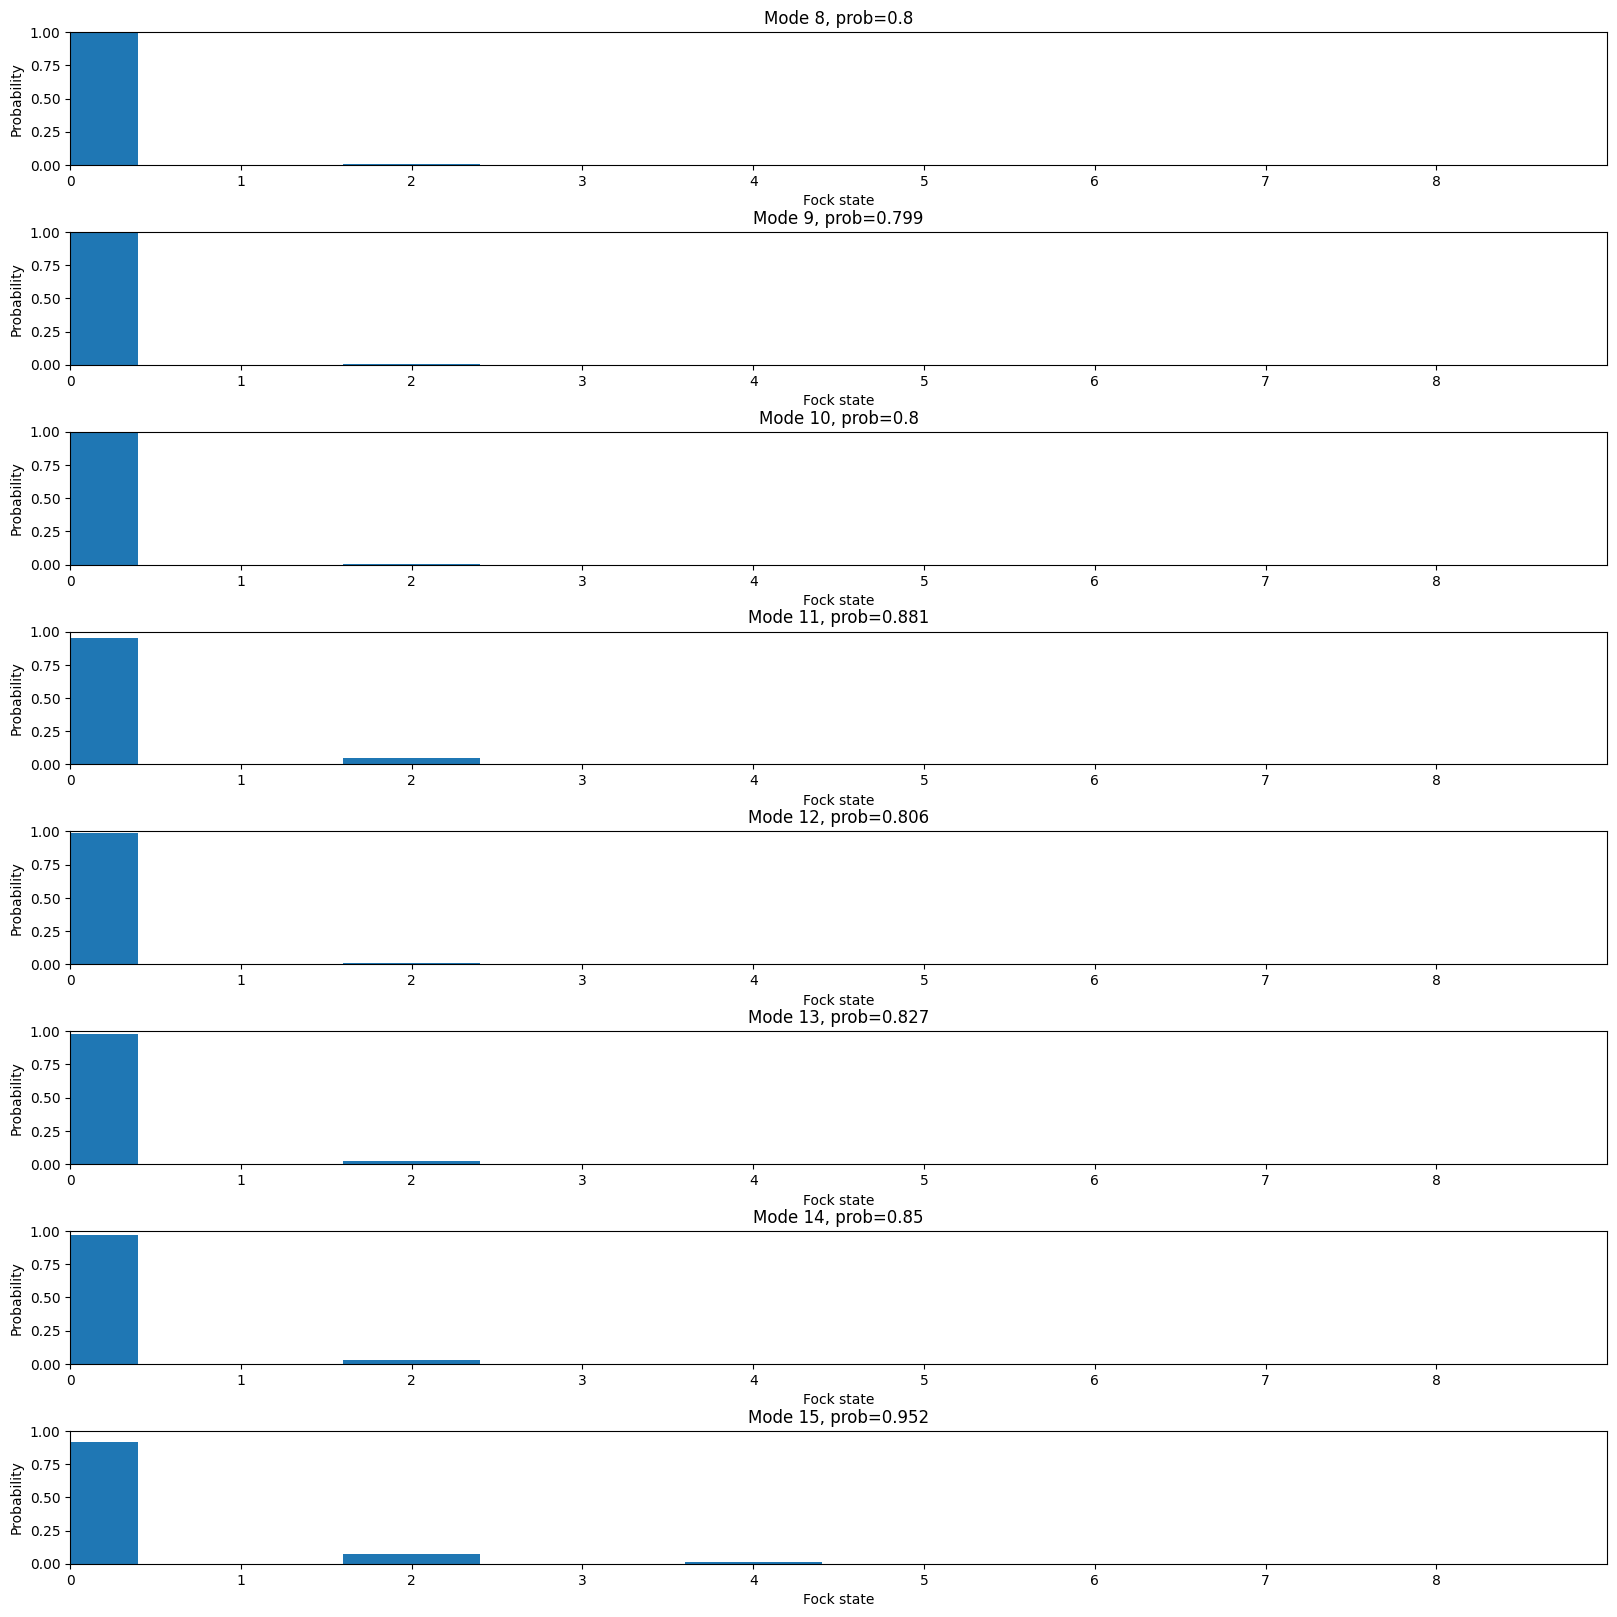

In [460]:
wl=1.55
r=0.5

sim=QuantumSim(ckt=sampler,wl=wl,a=inst,b=conn,c=ports,theta_arr=theta_arr,phi_arr=phi_arr)

i1=SqueezedState(port="int1",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i2=SqueezedState(port="inb1",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i3=SqueezedState(port="int2",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i4=SqueezedState(port="inb2",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i5=SqueezedState(port="int3",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i6=SqueezedState(port="inb3",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i7=SqueezedState(port="int4",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
i8=SqueezedState(port="inb4",r=r,alpha=0*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)

qstate=compose_qstate(i1,i2,i3,i4,i5,i6,i7,i8)

sim.add_qstate(qstate=qstate)
res=sim.run()
res_state=res.state()
# i2.plot_mode(mode=0)



fig,ax=plt.subplots(8,1,figsize=(16,16))
cutoff=9
k=0
ind=0

pdf=np.zeros((8,cutoff))
for i in range(8,16):
        means, cov = res_state.modes(i)
        fock_amp = tw.quantum.state_vector(means, cov, cutoff=cutoff, hbar=1/2, check_purity=False)
        # ax=plt.subplot(2,2,i-1)

        prob=np.sum(abs(fock_amp)**2) 
        prob=round(prob,3)   
        p_arr=np.array(abs(fock_amp)**2)
        p_arr=p_arr/np.sum(p_arr)
        # prob=round(np.sum(p_arr),3)
        # if k>=8:
        pdf[k]=p_arr
        #  ind+=1

        # ax[i].set_title(f'Mode {i}, prob={prob}')
       

        # ax[k].bar(range(len(fock_amp)), abs(fock_amp) ** 2)
        ax[k].bar(range(len(fock_amp)), p_arr)
        ax[k].set_xticks(range(len(fock_amp)))
        ax[k].set_xlabel("Fock state")
        ax[k].set_ylabel("Probability")
        ax[k].set_ylim([0, 1])
        ax[k].set_xlim([0, cutoff])
        ax[k].set_title(f'Mode {i}, prob={prob}')
        k+=1

# plt.tight_layout()
plt.tight_layout(pad=0.1)
plt.show()

In [435]:
from simphony.utils import xxpp_to_xpxp
import pandas as pd

In [124]:
np.arange(64).reshape((8,8))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [203]:
cc=xxpp_to_xpxp(np.arange(64).reshape((8,8)))
cc

array([[ 0,  4,  1,  5,  2,  6,  3,  7],
       [32, 36, 33, 37, 34, 38, 35, 39],
       [ 8, 12,  9, 13, 10, 14, 11, 15],
       [40, 44, 41, 45, 42, 46, 43, 47],
       [16, 20, 17, 21, 18, 22, 19, 23],
       [48, 52, 49, 53, 50, 54, 51, 55],
       [24, 28, 25, 29, 26, 30, 27, 31],
       [56, 60, 57, 61, 58, 62, 59, 63]])

In [436]:
m_array=[1]
inds = np.concatenate(([0,2],[3,1]))
A=cc[np.ix_(inds,inds)]
A

array([[ 0,  1,  5,  4],
       [ 8,  9, 13, 12],
       [40, 41, 45, 44],
       [32, 33, 37, 36]])

In [461]:
cv=res_state.cov
cov_mat=xxpp_to_xpxp(res_state.cov)

Cov_mat=cov_mat[15:31,15:31]
dat=pd.DataFrame(Cov_mat)

# res_state.modes(31)
# len(cov_mat)
dat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.355996,-0.084690,-0.036862,-0.016884,0.112932,0.026344,0.016771,0.033200,-0.149337,-0.115814,0.074083,0.127607,-0.054328,-0.010683,-0.024665
2,0.00,-0.084690,0.415544,-0.016884,0.036862,0.026344,-0.112932,0.033200,-0.016771,-0.115814,0.149337,0.127607,-0.074083,-0.010683,0.054328,-0.024990
3,0.00,-0.036862,-0.016884,0.467761,0.032089,0.136961,-0.124628,-0.031636,-0.052673,0.129510,-0.066549,0.011130,-0.042816,-0.104233,-0.040409,-0.056479
4,0.00,-0.016884,0.036862,0.032089,0.303779,-0.124628,-0.136961,-0.052673,0.031636,-0.066549,-0.129510,-0.042816,-0.011130,-0.040409,0.104233,0.003327
5,0.00,0.112932,0.026344,0.136961,-0.124628,0.370687,0.091342,-0.011885,-0.032608,-0.037683,0.020327,0.099766,-0.067422,-0.085328,0.007913,-0.045656
6,0.00,0.026344,-0.112932,-0.124628,-0.136961,0.091342,0.400853,-0.032608,0.011885,0.020327,0.037683,-0.067422,-0.099766,0.007913,0.085328,-0.055181
7,0.00,0.016771,0.033200,-0.031636,-0.052673,-0.011885,-0.032608,0.593279,0.071440,-0.018499,0.008325,-0.073009,-0.038546,-0.108198,-0.108982,0.005630
8,0.00,0.033200,-0.016771,-0.052673,0.031636,-0.032608,0.011885,0.071440,0.178261,0.008325,0.018499,-0.038546,0.073009,-0.108982,0.108198,0.030797
9,0.00,-0.149337,-0.115814,0.129510,-0.066549,-0.037683,0.020327,-0.018499,0.008325,0.378682,0.109369,-0.089626,0.073062,-0.037481,-0.015386,0.010357


In [438]:
def find_combinations(target, current_combination, start, comb_dict):
    global cind
    if target == 0:
        p = 0
        for k in current_combination:
            if k % 2 != 0:
                p += 1
        if p == 0:
            # print(current_combination)
            comb_dict[cind] = current_combination.copy()
            cind += 1
        return
    
    elif target < 0:
        return
    else:
        for i in range(start, target + 1):
            current_combination.append(i)
            find_combinations(target - i, current_combination, i, comb_dict)
            current_combination.pop()

# Example usage:
if __name__ == "__main__":
    target_number = 8
    print(f"Number combinations that sum up to {target_number} with all even numbers:")
    comb_dict = {}
    cind = 0  # Initialize cind outside of the function
    find_combinations(target_number, [], 2, comb_dict)
    # print("Combinations stored in comb_dict:")
    # print(comb_dict)
comb_dict

Number combinations that sum up to 8 with all even numbers:


{0: [2, 2, 2, 2], 1: [2, 2, 4], 2: [2, 6], 3: [4, 4], 4: [8]}

In [439]:
comb_mat=np.zeros((len(comb_dict),8),dtype=int)
i=0
for key,value in comb_dict.items():
    v=len(value)
    z=np.zeros(8-v,dtype=int)
    val=np.array(value)
    new_val=np.concatenate((val,z),dtype=int)
    comb_mat[i]=new_val
    i+=1
from itertools import permutations

def shuffle_array(array):
    # Generate all permutations of the array
    all_permutations = permutations(array)
    
    # Convert permutations iterator to a list of tuples
    all_permutations_list = list(all_permutations)
    new_list=np.array(all_permutations_list,dtype=int)
    
    return new_list
comb_mat

array([[2, 2, 2, 2, 0, 0, 0, 0],
       [2, 2, 4, 0, 0, 0, 0, 0],
       [2, 6, 0, 0, 0, 0, 0, 0],
       [4, 4, 0, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 0, 0, 0, 0]])

In [440]:

def trans(A,arr):
    
    sum=np.sum(arr)
    D=np.eye(int(sum))
    j=0
    d=0 
    for a in arr:   
        if a==0:
            j+=1
        else:
            one=np.ones((a,a))*A[j,j]
            D[d:d+a,d:d+a]=one
            d+=a
            j+=1

    new_dict={}
    for (i, j), value in np.ndenumerate(A):
        new_dict[value]=[i,j]
    new_dict

    new_arr=D.copy()
    for (i, j), value in np.ndenumerate(D):
        if value==0:
            
            a=D[i,i]
            b=D[j,j]
            a_ind = new_dict[a]
            b_ind = new_dict[b]
        
            
        
            for key, (d_i, d_j) in new_dict.items():
                if (d_i, d_j) == (a_ind[0], b_ind[0]):
                    
                    new_arr[i, j] = key
   
    
    return new_arr

def sub_mat(mat,arr):
    n=int(mat.shape[0]/2)
    A=mat[:n,:n]
    B=mat[:n,n:]
    C=mat[n:,n:]

    a_new=trans(A,arr)
    b_new=trans(B,arr)
    c_new=trans(C,arr)

    
    s=a_new.shape[0]
    As=np.eye(2*s)
    As[:s,:s]=a_new
    As[s:,:s]=b_new
    As[:s,s:]=b_new.T
    As[s:,s:]=c_new
    return As


In [441]:
## loop for each photon value,
#loop for each specific permutation for each value
#compute hafnina
# store prob


In [462]:
A=Amat(Cov_mat)
Q=Qmat(Cov_mat)
Cov=cv

dt=np.linalg.det(Q)
det=1/(np.sqrt(dt.real))
det

23.525541771972144

In [443]:
q=[1,2]
q[0:2]

[1, 2]

In [463]:
c_ar=[0,2,4,6,8]
c_ar=[0,2,4,6,8]
p_dict={}
perm_dict={}
perm_mat=[[]]

prev_prob=[1]

for m in range(8):
    m_array=np.array([m])
    inds = np.concatenate((m_array, (m_array + 8)))
    A=Cov[np.ix_(inds,inds)]
    Q=Qmat(A)
    dt=np.linalg.det(Q)
    det=1/(np.sqrt(dt.real))

    next_mat=[]
    inter_prob=[]
    pind=0
    prob_mat=[]
    for perm in perm_mat:
        
        
        for a in c_ar:         
            ar=perm.copy()
            ar.append(a) 

            if np.sum(ar)>8:
                break
            # elif m==max(range(8)):
                
            #     if np.sum(ar)!=8:
            #         None
            #     else:
            #         fact=1
            #         for factor in ar:
            #             fact=fact*factorial(factor)      
            #         As=sub_mat(A,ar)
            #         haf=hf._haf(As)
            #         prob=haf/(det*fact)
            #         prob=prob/prev_prob[pind]
                    
            #         prob_mat.append(prob.real)


            #         inter_prob.append(prob)         
            #         next_mat.append(ar)
            else:
                fact=1
                for factor in ar:
                    fact=fact*factorial(factor)      
                As=sub_mat(A,ar)
                haf=hf._haf(As)
                prob=haf/(det*fact)
                prob=prob/prev_prob[pind]
                
                prob_mat.append(prob.real)


                inter_prob.append(prob)         
                next_mat.append(ar)

        pind+=1
    prev_prob=inter_prob
    perm_mat=next_mat

In [464]:
(perm_mat)

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 2],
 [0, 0, 0, 0, 0, 0, 0, 4],
 [0, 0, 0, 0, 0, 0, 0, 6],
 [0, 0, 0, 0, 0, 0, 0, 8],
 [0, 0, 0, 0, 0, 0, 2, 0],
 [0, 0, 0, 0, 0, 0, 2, 2],
 [0, 0, 0, 0, 0, 0, 2, 4],
 [0, 0, 0, 0, 0, 0, 2, 6],
 [0, 0, 0, 0, 0, 0, 4, 0],
 [0, 0, 0, 0, 0, 0, 4, 2],
 [0, 0, 0, 0, 0, 0, 4, 4],
 [0, 0, 0, 0, 0, 0, 6, 0],
 [0, 0, 0, 0, 0, 0, 6, 2],
 [0, 0, 0, 0, 0, 0, 8, 0],
 [0, 0, 0, 0, 0, 2, 0, 0],
 [0, 0, 0, 0, 0, 2, 0, 2],
 [0, 0, 0, 0, 0, 2, 0, 4],
 [0, 0, 0, 0, 0, 2, 0, 6],
 [0, 0, 0, 0, 0, 2, 2, 0],
 [0, 0, 0, 0, 0, 2, 2, 2],
 [0, 0, 0, 0, 0, 2, 2, 4],
 [0, 0, 0, 0, 0, 2, 4, 0],
 [0, 0, 0, 0, 0, 2, 4, 2],
 [0, 0, 0, 0, 0, 2, 6, 0],
 [0, 0, 0, 0, 0, 4, 0, 0],
 [0, 0, 0, 0, 0, 4, 0, 2],
 [0, 0, 0, 0, 0, 4, 0, 4],
 [0, 0, 0, 0, 0, 4, 2, 0],
 [0, 0, 0, 0, 0, 4, 2, 2],
 [0, 0, 0, 0, 0, 4, 4, 0],
 [0, 0, 0, 0, 0, 6, 0, 0],
 [0, 0, 0, 0, 0, 6, 0, 2],
 [0, 0, 0, 0, 0, 6, 2, 0],
 [0, 0, 0, 0, 0, 8, 0, 0],
 [0, 0, 0, 0, 2, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 0, 2],
 

In [446]:

len(perm_mat)
# pind
# # inter_prob
# # # max(range(7))
# len(prob_mat)


495

In [466]:
sum_arr=[]
for pee in perm_mat:
    s=np.sum(pee)
    sum_arr.append(s)



In [467]:
sorted_indices = np.argsort(np.array(sum_arr))
sorted_indices.reshape(-1)
# Sort the array using the sorted indices
sort_arr=[]
p_new=prob_mat.copy()
for sor in sorted_indices:
    sort_arr.append(p_new[sor])
# sorted_array
p_new=sort_arr

In [468]:
p_new=p_new/np.sum(p_new)
his=[]
for sam in range(100000):
    qq=np.random.choice(range(len(prob_mat)),p=p_new)
    his.append(qq)

(-1.0, 495.0)

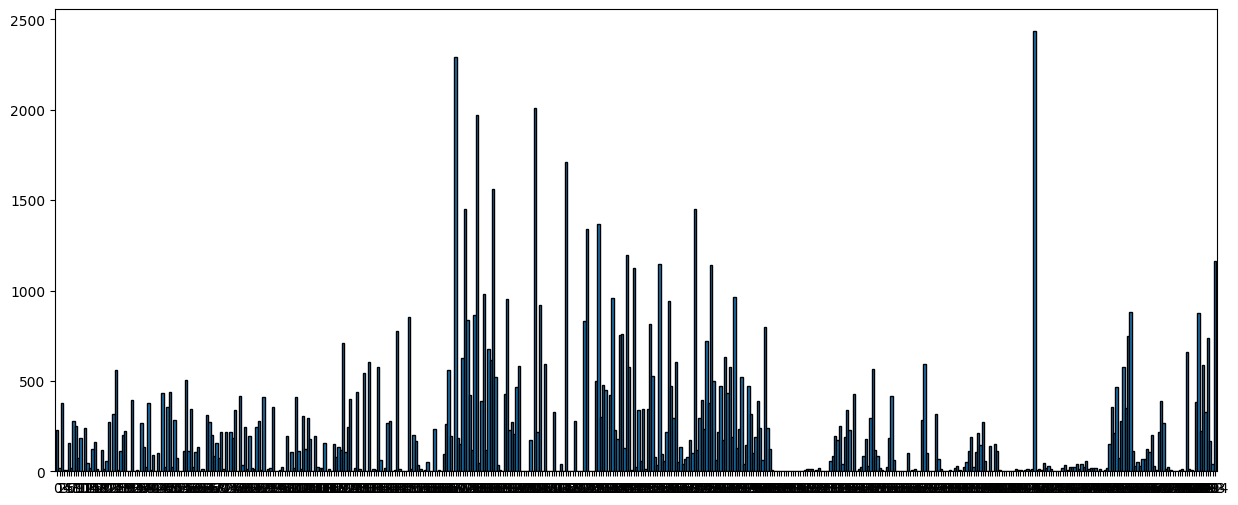

In [469]:
p_new=p_new/np.sum(p_new)



plt.figure(figsize=(15,6))
plt.hist(his,bins=range(min(his), max(his) + 2) ,align='left', edgecolor='black')
plt.xticks(range(max(his)+1))
plt.xlim([-1,max(his)+1])

In [470]:
bin_perm=perm_mat.copy()
bin_prob=prob_mat.copy()
# bin_prob

In [471]:
binn_comb=[]
for pp in bin_perm:
    a=pp[0:4]
    b=pp[4:]
    a=np.sum(a)
    b=np.sum(b)
    binn=[a,b]
    binn_comb.append(binn)

binn_comb



[[0, 0],
 [0, 2],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 2],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 2],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 8],
 [0, 2],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 8],
 [0, 4],
 [0, 6],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 8],
 [0, 6],
 [0, 8],
 [0, 8],
 [0, 8],
 [0, 8],
 [2, 0],
 [2, 2],
 [2, 4],
 [2, 6],
 [2, 2],
 [2, 4],
 [2, 6],
 [2, 4],
 [2, 6],
 [2, 6],
 [2, 2],
 [2, 4],
 [2, 6],
 [2, 4],
 [2, 6],
 [2, 6],
 [2, 4],
 [2, 6],
 [2, 6],
 [2, 6],
 [2, 2],
 [2, 4],
 [2, 6],
 [2, 4],
 [2, 6],
 [2, 6],
 [2, 4],
 [2, 6],
 [2, 6],
 [2, 6],
 [2, 4],
 [2, 6],
 [2, 6],
 [2, 6],
 [2, 6],
 [4, 0],
 [4, 2],
 [4, 4],
 [4, 2],
 [4, 4],
 [4, 4],
 

In [472]:
unique_bin,counts_bin = np.unique(binn_comb,axis=0, return_counts=True)
# (unique_bin)



In [473]:
ind_ar=[]
for u in unique_bin:
    for ind,b in enumerate(binn_comb):
        if np.array_equal(u, b):
            ind_ar.append(ind)
            break


last_prob=[]
for i in ind_ar:
  last_prob.append(bin_prob[i])


h_prob=np.multiply(last_prob,counts_bin)
# h_prob=last_prob

h_mat=h_prob/np.sum(h_prob)
(h_mat)

array([4.13335589e-01, 7.38118226e-02, 1.23572074e-02, 1.83891738e-03,
       2.51420944e-04, 8.62901824e-02, 1.38684213e-01, 6.44939431e-02,
       1.88112166e-02, 1.68885067e-02, 7.53970559e-02, 6.87230403e-02,
       2.93811365e-03, 2.57091549e-02, 4.69616431e-04])

In [474]:
# h_mat=h_prob/np.sum(h_prob)



In [475]:
sum=[]
for u in unique_bin:
    ss=np.sum(u)
    sum.append(ss)
    
sorted_indices = np.argsort(np.array(sum))
sorted_indices.reshape(-1)
# Sort the array using the sorted indices
sort_arr=[]
new_bin_ar=[]
p_new=h_mat.copy()
for sor in sorted_indices:
    sort_arr.append(p_new[sor])
    new_bin_ar.append(unique_bin[sor])
# sorted_array
h_mat=sort_arr


In [476]:
new_bin_ar

[array([0, 0]),
 array([0, 2]),
 array([2, 0]),
 array([0, 4]),
 array([2, 2]),
 array([4, 0]),
 array([0, 6]),
 array([2, 4]),
 array([4, 2]),
 array([6, 0]),
 array([0, 8]),
 array([2, 6]),
 array([4, 4]),
 array([6, 2]),
 array([8, 0])]

In [477]:
his=[]
for sam in range(100000):
    qq=np.random.choice(range(len(unique_bin)),p=h_mat)
    his.append(qq)




unique_bin

array([[0, 0],
       [0, 2],
       [0, 4],
       [0, 6],
       [0, 8],
       [2, 0],
       [2, 2],
       [2, 4],
       [2, 6],
       [4, 0],
       [4, 2],
       [4, 4],
       [6, 0],
       [6, 2],
       [8, 0]])

(-1.0, 15.0)

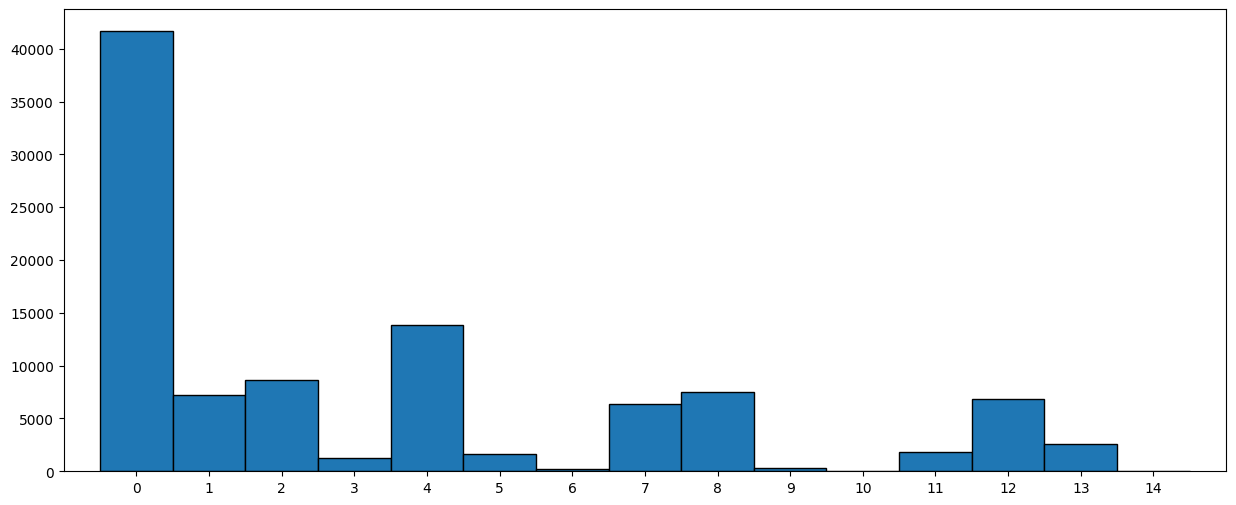

In [479]:


plt.figure(figsize=(15,6))
plt.hist(his,bins=range(min(his), max(his) + 2) ,align='left', edgecolor='black')
plt.xticks(range(max(his)+1))
plt.xlim([-1,max(his)+1])






In [482]:
len(perm_mat)
n_mat=[]
for g in perm_mat:
    if np.sum(g)==8:
        n_mat.append(g)

len(n_mat)

330

In [483]:
#det binning

In [485]:
c_ar=[0,2,4,6,8]

perm_dict={}
perm_mat=[[]]

prev_prob=[1]
B=[]


for m in range(8):
    m_array=np.array([m])
    inds = np.concatenate((m_array, (m_array + 8)))
    A=Cov[np.ix_(inds,inds)]
    Q=Qmat(A)
    dt=np.linalg.det(Q)
    det=1/(np.sqrt(dt.real))

    next_mat=[]
    inter_prob=[]
    pind=0
    prob_mat=[]
    for perm in perm_mat:
        
        
        for a in c_ar:         
            ar=perm.copy()
            ar.append(a) 

            if np.sum(ar)>8:
                break
            # elif m==max(range(8)):
                
            #     if np.sum(ar)!=8:
            #         None
            #     else:
            #         fact=1
            #         for factor in ar:
            #             fact=fact*factorial(factor)      
            #         As=sub_mat(A,ar)
            #         haf=hf._haf(As)
            #         prob=haf/(det*fact)
            #         prob=prob/prev_prob[pind]
                    
            #         prob_mat.append(prob.real)


            #         inter_prob.append(prob)         
            #         next_mat.append(ar)
            else:
                fact=1
                for factor in ar:
                    fact=fact*factorial(factor)      
                As=sub_mat(A,ar)
                haf=hf._haf(As)
                prob=haf/(det*fact)
                prob=prob/prev_prob[pind]
                
                prob_mat.append(prob.real)


                inter_prob.append(prob)         
                next_mat.append(ar)

        pind+=1
    prev_prob=inter_prob
    perm_mat=next_mat





In [486]:

tot_count_dict={}
total_haf_dict={}
for nind in range(comb_mat.shape[0]):
# for nind in range(1):

    ar=comb_mat[nind]
    aa=shuffle_array(ar)

    unique_rows,counts = np.unique(aa,axis=0, return_counts=True)
    rep_arr = unique_rows.tolist()  # matrix with each perm
    # length_unique_rows = len(rep_arr)

    count_dict = {tuple(arr): count for arr, count in zip(unique_rows, counts)}  # info about each perm and its count
       
    haf_dict={}
    for k,v in count_dict.items():    

        arr=np.array(k)
        fact=1
        for k_val in np.array(k):
            fact=fact*factorial(k_val)
        As=sub_mat(Cov_mat,arr)
        haf=hf._haf(As)
        haf_dict[k]=(v*haf/(fact*det)).real

    total_haf_dict.update(haf_dict)
    tot_count_dict.update(count_dict)

In [487]:
len(total_haf_dict)
total_haf_dict

{(0, 0, 0, 0, 2, 2, 2, 2): 0.04975512880433893,
 (0, 0, 0, 2, 0, 2, 2, 2): 0.05143491664124021,
 (0, 0, 0, 2, 2, 0, 2, 2): 0.03383626815903918,
 (0, 0, 0, 2, 2, 2, 0, 2): 0.025294503567732978,
 (0, 0, 0, 2, 2, 2, 2, 0): 0.03383476511884988,
 (0, 0, 2, 0, 0, 2, 2, 2): 0.06398769296538453,
 (0, 0, 2, 0, 2, 0, 2, 2): 0.06013619371800714,
 (0, 0, 2, 0, 2, 2, 0, 2): 0.03156731851654572,
 (0, 0, 2, 0, 2, 2, 2, 0): 0.0459274448227096,
 (0, 0, 2, 2, 0, 0, 2, 2): 0.03956358072465001,
 (0, 0, 2, 2, 0, 2, 0, 2): 0.032643857525931054,
 (0, 0, 2, 2, 0, 2, 2, 0): 0.0446584526569701,
 (0, 0, 2, 2, 2, 0, 0, 2): 0.03710902967125923,
 (0, 0, 2, 2, 2, 0, 2, 0): 0.04203380653100549,
 (0, 0, 2, 2, 2, 2, 0, 0): 0.02653357066633506,
 (0, 2, 0, 0, 0, 2, 2, 2): 0.07310450600559364,
 (0, 2, 0, 0, 2, 0, 2, 2): 0.0557512570271693,
 (0, 2, 0, 0, 2, 2, 0, 2): 0.04572159450181814,
 (0, 2, 0, 0, 2, 2, 2, 0): 0.06402723098822125,
 (0, 2, 0, 2, 0, 0, 2, 2): 0.04620274923791402,
 (0, 2, 0, 2, 0, 2, 0, 2): 0.037409833333

In [488]:
s=0
for e,t in total_haf_dict.items():
    s+=t

s

30.558536498858057

In [489]:
y=0
for k,v in count_dict.items():  
    if y==0:
        print(np.array(k))
        y+=1
        fact=1
        for k_val in np.array(k):
            fact=fact*factorial(k_val)

fact

[0 0 0 0 0 0 0 8]


40320.0

In [490]:
ar=comb_mat[0]
aa=shuffle_array(ar)
len(aa)

40320

In [491]:

unique_rows,counts = np.unique(aa,axis=0, return_counts=True)
rep_arr = unique_rows.tolist()
length_unique_rows = len(rep_arr)
print("Unique Rows (rep_arr):")
print(rep_arr)
print("Length of Unique Rows:")
print(length_unique_rows)


Unique Rows (rep_arr):
[[0, 0, 0, 0, 2, 2, 2, 2], [0, 0, 0, 2, 0, 2, 2, 2], [0, 0, 0, 2, 2, 0, 2, 2], [0, 0, 0, 2, 2, 2, 0, 2], [0, 0, 0, 2, 2, 2, 2, 0], [0, 0, 2, 0, 0, 2, 2, 2], [0, 0, 2, 0, 2, 0, 2, 2], [0, 0, 2, 0, 2, 2, 0, 2], [0, 0, 2, 0, 2, 2, 2, 0], [0, 0, 2, 2, 0, 0, 2, 2], [0, 0, 2, 2, 0, 2, 0, 2], [0, 0, 2, 2, 0, 2, 2, 0], [0, 0, 2, 2, 2, 0, 0, 2], [0, 0, 2, 2, 2, 0, 2, 0], [0, 0, 2, 2, 2, 2, 0, 0], [0, 2, 0, 0, 0, 2, 2, 2], [0, 2, 0, 0, 2, 0, 2, 2], [0, 2, 0, 0, 2, 2, 0, 2], [0, 2, 0, 0, 2, 2, 2, 0], [0, 2, 0, 2, 0, 0, 2, 2], [0, 2, 0, 2, 0, 2, 0, 2], [0, 2, 0, 2, 0, 2, 2, 0], [0, 2, 0, 2, 2, 0, 0, 2], [0, 2, 0, 2, 2, 0, 2, 0], [0, 2, 0, 2, 2, 2, 0, 0], [0, 2, 2, 0, 0, 0, 2, 2], [0, 2, 2, 0, 0, 2, 0, 2], [0, 2, 2, 0, 0, 2, 2, 0], [0, 2, 2, 0, 2, 0, 0, 2], [0, 2, 2, 0, 2, 0, 2, 0], [0, 2, 2, 0, 2, 2, 0, 0], [0, 2, 2, 2, 0, 0, 0, 2], [0, 2, 2, 2, 0, 0, 2, 0], [0, 2, 2, 2, 0, 2, 0, 0], [0, 2, 2, 2, 2, 0, 0, 0], [2, 0, 0, 0, 0, 2, 2, 2], [2, 0, 0, 0, 2, 0, 2, 2], [2, 0, 0, 0, 2

In [492]:
count_dict = {tuple(arr): count for arr, count in zip(unique_rows, counts)}
len(count_dict)
count_dict

{(0, 0, 0, 0, 2, 2, 2, 2): 576,
 (0, 0, 0, 2, 0, 2, 2, 2): 576,
 (0, 0, 0, 2, 2, 0, 2, 2): 576,
 (0, 0, 0, 2, 2, 2, 0, 2): 576,
 (0, 0, 0, 2, 2, 2, 2, 0): 576,
 (0, 0, 2, 0, 0, 2, 2, 2): 576,
 (0, 0, 2, 0, 2, 0, 2, 2): 576,
 (0, 0, 2, 0, 2, 2, 0, 2): 576,
 (0, 0, 2, 0, 2, 2, 2, 0): 576,
 (0, 0, 2, 2, 0, 0, 2, 2): 576,
 (0, 0, 2, 2, 0, 2, 0, 2): 576,
 (0, 0, 2, 2, 0, 2, 2, 0): 576,
 (0, 0, 2, 2, 2, 0, 0, 2): 576,
 (0, 0, 2, 2, 2, 0, 2, 0): 576,
 (0, 0, 2, 2, 2, 2, 0, 0): 576,
 (0, 2, 0, 0, 0, 2, 2, 2): 576,
 (0, 2, 0, 0, 2, 0, 2, 2): 576,
 (0, 2, 0, 0, 2, 2, 0, 2): 576,
 (0, 2, 0, 0, 2, 2, 2, 0): 576,
 (0, 2, 0, 2, 0, 0, 2, 2): 576,
 (0, 2, 0, 2, 0, 2, 0, 2): 576,
 (0, 2, 0, 2, 0, 2, 2, 0): 576,
 (0, 2, 0, 2, 2, 0, 0, 2): 576,
 (0, 2, 0, 2, 2, 0, 2, 0): 576,
 (0, 2, 0, 2, 2, 2, 0, 0): 576,
 (0, 2, 2, 0, 0, 0, 2, 2): 576,
 (0, 2, 2, 0, 0, 2, 0, 2): 576,
 (0, 2, 2, 0, 0, 2, 2, 0): 576,
 (0, 2, 2, 0, 2, 0, 0, 2): 576,
 (0, 2, 2, 0, 2, 0, 2, 0): 576,
 (0, 2, 2, 0, 2, 2, 0, 0): 576,
 (0, 2, 

In [493]:
ii=0
for k,v in count_dict.items():
    if ii==0:
        print(np.array(k))
        ii+=1

[0 0 0 0 2 2 2 2]


In [494]:

A=Amat(Cov_mat)
Q=Qmat(Cov_mat)

In [495]:

def trans(A,arr):
    
    sum=np.sum(arr)
    D=np.eye(int(sum))
    j=0
    d=0 
    for a in arr:   
        if a==0:
            j+=1
        else:
            one=np.ones((a,a))*A[j,j]
            D[d:d+a,d:d+a]=one
            d+=a
            j+=1

    new_dict={}
    for (i, j), value in np.ndenumerate(A):
        new_dict[value]=[i,j]
    new_dict

    new_arr=D.copy()
    for (i, j), value in np.ndenumerate(D):
        if value==0:
            
            a=D[i,i]
            b=D[j,j]
            a_ind = new_dict[a]
            b_ind = new_dict[b]
        
            
        
            for key, (d_i, d_j) in new_dict.items():
                if (d_i, d_j) == (a_ind[0], b_ind[0]):
                    
                    new_arr[i, j] = key
   
    
    return new_arr



In [496]:
arr=[0,0,2,2,2,2,0,0]
T=trans(Cov_mat,arr)

In [497]:
from thewalrus import hafnian
hafnian(np.array(Cov_mat,dtype=np.complex128)).real

0.0

In [498]:
hf._haf(T)


(0.022646870776301023+0j)

In [499]:
def sub_mat(mat,arr):
    n=int(mat.shape[0]/2)
    A=mat[:n,:n]
    B=mat[:n,n:]
    C=mat[n:,n:]
    a_new=trans(A,arr)
    b_new=trans(B,arr)
    c_new=trans(C,arr)
    s=a_new.shape[0]
    As=np.eye(2*s)
    As[:s,:s]=a_new
    As[s:,:s]=b_new
    As[:s,s:]=b_new.T
    As[s:,s:]=c_new
    return As

In [500]:

mat=np.arange(36).reshape((6,6))
arr=[3,0,1]
As=sub_mat(mat,arr)
As


array([[ 0.,  0.,  0.,  2.,  3.,  3.,  3., 15.],
       [ 0.,  0.,  0.,  2.,  3.,  3.,  3., 15.],
       [ 0.,  0.,  0.,  2.,  3.,  3.,  3., 15.],
       [12., 12., 12., 14.,  5.,  5.,  5., 17.],
       [ 3.,  3.,  3.,  5., 21., 21., 21., 23.],
       [ 3.,  3.,  3.,  5., 21., 21., 21., 23.],
       [ 3.,  3.,  3.,  5., 21., 21., 21., 23.],
       [15., 15., 15., 17., 33., 33., 33., 35.]])

In [501]:
arr=np.array(ar)
As=sub_mat(Cov_mat,arr)


In [502]:
arr=np.array(ar)
As=sub_mat(Cov_mat,arr)
hf._haf(As)

(0.0005306429836374194+0j)

In [503]:
arr=[3,0,1]
a_new=trans(A,arr)
b_new=trans(B,arr)
c_new=trans(C,arr)


C:\Users\akhil\AppData\Local\Temp\ipykernel_10956\3478145850.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  D[d:d+a,d:d+a]=one


KeyError: 0.0687134921879723

In [ ]:
s=a_new.shape[0]
As=np.eye(2*s)
As[:s,:s]=a_new
As[s:,:s]=b_new
As[:s,s:]=b_new.T
As[s:,s:]=c_new

In [504]:
As

array([[ 0.25      ,  0.25      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03320045,  0.03320045, -0.01677129, -0.01677129, -0.05267262,
        -0.05267262],
       [ 0.25      ,  0.25      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03320045,  0.03320045, -0.01677129, -0.01677129, -0.05267262,
        -0.05267262],
       [ 0.        ,  0.        ,  0.3559962 ,  0.3559962 ,  0.        ,
         0.        , -0.03686165, -0.03686165,  0.        ,  0.        ,
        -0.14933669, -0.14933669, -0.11581406, -0.11581406,  0.12950959,
         0.12950959],
       [ 0.        ,  0.        ,  0.3559962 ,  0.3559962 ,  0.        ,
         0.        , -0.03686165, -0.03686165,  0.        ,  0.        ,
        -0.14933669, -0.14933669, -0.11581406, -0.11581406,  0.12950959,
         0.12950959],
       [ 0.        ,  0.        , -0

In [505]:
new_dict={}
for (i, j), value in np.ndenumerate(A):
    new_dict[value]=[i,j]
new_dict


{(0.0687134921879723+1.7654675931055663e-19j): [0, 0],
 (-0.0045506337431364605-0.01815887985328108j): [0, 1],
 (-0.010109662124541424+0.009200240343667117j): [0, 2],
 (0.02093500662662983+0.028726966664088617j): [0, 3],
 (-0.03975309001942257-0.017121433878802616j): [0, 4],
 (0.05946488118527458+0.017654751905666025j): [0, 5],
 (-0.058963061068370355-0.006377037825236569j): [0, 6],
 (-0.017400142249288732-0.03888237583561474j): [0, 7],
 (-0.6687134921879612-3.9809006990846495e-19j): [0, 8],
 (0.004550633743136458-0.01815887985328108j): [0, 9],
 (0.010109662124541426+0.00920024034366711j): [0, 10],
 (-0.020935006626629834+0.028726966664088634j): [0, 11],
 (0.03975309001942257-0.01712143387880261j): [12, 0],
 (-0.05946488118527458+0.01765475190566602j): [0, 13],
 (0.058963061068370355-0.006377037825236574j): [0, 14],
 (0.017400142249288732-0.038882375835614734j): [0, 15],
 (-0.004550633743136462-0.018158879853281084j): [1, 0],
 (-0.012129085284039361+0.16274631760037542j): [1, 1],
 (-0.

In [506]:
new_dict={}
for (i, j), value in np.ndenumerate(A):
    new_dict[value]=[i,j]
new_dict

new_arr=new_ar.copy()
for (i, j), value in np.ndenumerate(new_ar):
    if value==0:
        
        a=new_ar[i,i]
        b=new_ar[j,j]
        a_ind = new_dict[a]
        b_ind = new_dict[b]
       
        
    
        for key, (d_i, d_j) in new_dict.items():
            if (d_i, d_j) == (a_ind[0], b_ind[0]):
                
                new_arr[i, j] = key
new_arr

NameError: name 'new_ar' is not defined

In [507]:
import numpy as np
from itertools import combinations

elements = [1, 2, 3, 4, 5, 6]
def perfect_matchings(elements):
    if len(elements) % 2 != 0:
        return []  # Perfect matching is only possible for an even number of elements
    
    if len(elements) == 2:
        return [[(elements[0], elements[1])]]  # Base case

    first_element = elements[0]
    remaining_elements = elements[1:]
    matchings = []

    for pair in combinations(remaining_elements, 1):
        first_pair = (first_element, pair[0])
        rest_elements = [e for e in remaining_elements if e != pair[0]]
        for rest_matching in perfect_matchings(rest_elements):
            matchings.append([first_pair] + rest_matching)

    return matchings

perfect_matchings(elements)

[[(1, 2), (3, 4), (5, 6)],
 [(1, 2), (3, 5), (4, 6)],
 [(1, 2), (3, 6), (4, 5)],
 [(1, 3), (2, 4), (5, 6)],
 [(1, 3), (2, 5), (4, 6)],
 [(1, 3), (2, 6), (4, 5)],
 [(1, 4), (2, 3), (5, 6)],
 [(1, 4), (2, 5), (3, 6)],
 [(1, 4), (2, 6), (3, 5)],
 [(1, 5), (2, 3), (4, 6)],
 [(1, 5), (2, 4), (3, 6)],
 [(1, 5), (2, 6), (3, 4)],
 [(1, 6), (2, 3), (4, 5)],
 [(1, 6), (2, 4), (3, 5)],
 [(1, 6), (2, 5), (3, 4)]]

In [508]:


def matrix_permanent(matrix, matchings):
    perm_sum = 0
    for matching in matchings:
        product = 1
        for pair in matching:
            i, j = pair
            product *= matrix[i-1, j-1]  # Adjust for 0-based indexing in Python
        perm_sum += product
    return perm_sum

# Example usage with the given 6x6 matrix
A = np.array([
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10, 11, 12],
    [13, 14, 15, 16, 17, 18],
    [19, 20, 21, 22, 23, 24],
    [25, 26, 27, 28, 29, 30],
    [31, 32, 33, 34, 35, 36]
])

# Generate perfect matchings for a 6-element set
elements = [1, 2, 3, 4, 5, 6]
matchings = perfect_matchings(elements)

# Calculate the permanent
perm = matrix_permanent(A, matchings)
print("Permanent of the matrix:", perm)


Permanent of the matrix: 14070


In [509]:
pp=[[1,2,3],[4,5,6]]
j=[[1,2,3]]
for ty in pp:
    print(ty)

[1, 2, 3]
[4, 5, 6]


In [510]:
import numpy as np

# Define the kernel matrix A (6x6 symmetric matrix)
A = np.array([
    [1, 2, 3, 4, 5, 6],
    [2, 7, 8, 9, 10, 11],
    [3, 8, 12, 13, 14, 15],
    [4, 9, 13, 16, 17, 18],
    [5, 10, 14, 17, 19, 20],
    [6, 11, 15, 18, 20, 21]
])

# Define s1, s2, s3
s1, s2, s3 = 3, 0, 3

# Construct AS based on s1, s2, s3
AS = np.zeros((12, 12), dtype=int)

# Fill the top-left block with the original A
AS[:6, :6] = A

# Repeat rows based on s1 and s3
for i in range(6):
    AS[i, 6:9] = np.repeat(A[i, :], s1)  # Repeat rows i and i+3 s1 times
    AS[6:9, i] = np.repeat(A[:, i], s1)  # Repeat columns i and i+3 s1 times

for i in range(6):
    AS[i+6, 6:9] = np.repeat(A[i, :], s3)  # Repeat rows i a


ValueError: could not broadcast input array from shape (18,) into shape (3,)

In [511]:

p1=pdf[0]
p2=pdf[1]
# Number of points
N = len(p1)

# Mean values
mean_p1 = np.mean(p1)
mean_p2 = np.mean(p2)

# Fluctuations
delta_p1 = p1 - mean_p1
delta_p2 = p2 - mean_p2

# Two-point correlation function
xi = np.outer(delta_p1, delta_p2) / N

print("Two-Point Correlation Function (xi):")
print(xi)


Two-Point Correlation Function (xi):
[[ 0.08654908 -0.01089443 -0.01029366 -0.01089443 -0.01088888 -0.01089443
  -0.01089438 -0.01089443 -0.01089443]
 [-0.01089759  0.00137174  0.0012961   0.00137174  0.00137104  0.00137174
   0.00137173  0.00137174  0.00137174]
 [-0.01027207  0.001293    0.0012217   0.001293    0.00129234  0.001293
   0.001293    0.001293    0.001293  ]
 [-0.01089759  0.00137174  0.0012961   0.00137174  0.00137104  0.00137174
   0.00137173  0.00137174  0.00137174]
 [-0.01089156  0.00137098  0.00129538  0.00137098  0.00137028  0.00137098
   0.00137098  0.00137098  0.00137098]
 [-0.01089759  0.00137174  0.0012961   0.00137174  0.00137104  0.00137174
   0.00137173  0.00137174  0.00137174]
 [-0.01089752  0.00137173  0.00129609  0.00137173  0.00137103  0.00137173
   0.00137173  0.00137173  0.00137173]
 [-0.01089759  0.00137174  0.0012961   0.00137174  0.00137104  0.00137174
   0.00137173  0.00137174  0.00137174]
 [-0.01089759  0.00137174  0.0012961   0.00137174  0.00137104

In [512]:
# plot_quantum_result(res, wl_ind=0, include_loss_modes=False)
# print('modes')

In [513]:
# mode_plot(res)

In [514]:
#sampler

def exp(pdf,N=8):
    # np.random.seed(42)
    mat=np.zeros((N,8))
    
    fock_num=range(pdf.shape[1])
    for n in range(N):
        arr=[]
        for i in range(pdf.shape[0]):
            ij=np.random.choice(fock_num,p=pdf[i])
            arr.append(ij)

        mat[n]=arr


    
    Mat=mat.T
    return Mat


##binning into two


def binning(pdf,binn=2):
    
    # np.random.seed(42)
    
    
    fock_num=range(pdf.shape[1])
    p=pdf.shape[0]
    b_arr=np.zeros(binn)
    r0=0
    r1=round(p/binn)
    r=r1


    for b in range(binn):

        arr=[]
        if r1>pdf.shape[1]:
            r1==pdf.shape[1]
        for i in range(r0,r1):
            ij=np.random.choice(fock_num,p=pdf[i])
            arr.append(ij)

        r0+=r
        r1+=r

        b_sum=np.sum(arr)
        if b_sum>8:
            b_sum=8
        b_arr[b]=b_sum
       


            
    return list(b_arr.astype(int))

    

def bin_exp(pdf,binn,num=100):

    B=[]
    for Num in range(num):
        ar=binning(pdf=pdf,binn=binn)
        B.append(ar)


    return B

In [515]:
exp(pdf,5)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [516]:
exp_res=bin_exp(pdf=pdf,binn=2,num=10000)


In [517]:
#x_arr
x_ar=[]
C_dict={}

cut_min=0
for cut in range(cutoff):
    c_ar=[]
    for c1 in range(cut+1):
        c2=cut-c1    
        ar=[c1,c2]
        c_ar.append(ar)
        cut_min+=1

    x_ar.extend(c_ar)



x_dict={}
xx=0
for x in x_ar:
    x_dict[xx]=[]
    x_dict[xx]=x
    xx+=1
    
hist_arr=[]

for c_key,c_val in x_dict.items():
    
    for e_arr in exp_res:
    
        if c_val==e_arr:
            hist_arr.append(c_key)
            
            
    
nn=range(100)
N=[]

for rr in hist_arr:
    if rr in nn:
        if  rr in N:
           None
        else:
         N.append(rr)
len(N)

13

In [518]:
len(x_dict)

45

(-1.0, 41.0)

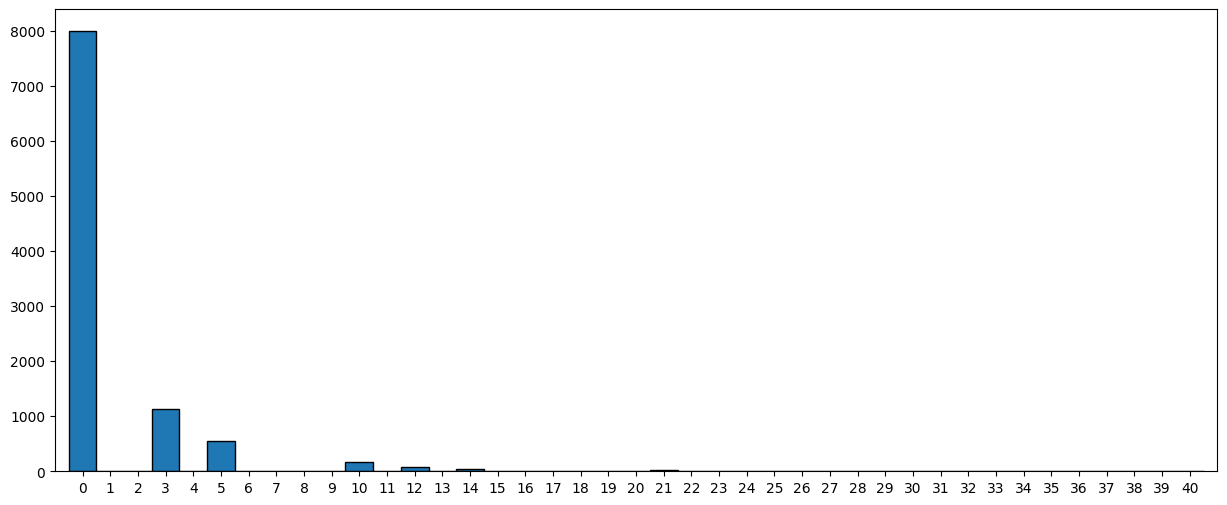

In [519]:
plt.figure(figsize=(15,6))


# plt.hist(hist_arr,bins=len(hist_arr))
plt.hist(hist_arr,bins=range(min(hist_arr), max(hist_arr) + 2) ,align='left', edgecolor='black')
# plt.ylim([0,1])
plt.xticks(range(max(hist_arr)+1))
plt.xlim([-1,max(hist_arr)+1])
# plt.ylim([0,200])
